# Create Visualization for Portfolio Sector/Industry Weights

Function:  Industry Weights

* Input (1 portfolio)

    * Dataframe
        * Columns
        * Ticker
        * shares per ticker
        * Industry
    * Goal: Specific Dates - input from dashboard

        
* Output

    * Industry weight for portfolio
    * Sector weight for portfolio(?)
 

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from datetime import date
from datetime import timedelta

from pathlib import Path
import requests
import json
import os
from dotenv import load_dotenv

%matplotlib inline


In [2]:
# import csv
# from pathlib import Path
# import pandas as pd
# from pandas import DataFrame
# import os
# from dotenv import load_dotenv
# from datetime import datetime
# from datetime import date
# from datetime import timedelta


# import requests
# import json

In [3]:
# Set the path for the csv files

portfolio_csv = Path("TestPortfolio.csv")
stock_csv = Path("stock_dict.csv")

# Reading csv files

portfolio_df = pd.read_csv(portfolio_csv, index_col="Date", parse_dates=True, infer_datetime_format=True)
stock_df = pd.read_csv(stock_csv, index_col="Unnamed: 0", parse_dates=True,infer_datetime_format=True )


In [4]:
stock_df

,AAPL,GOOG,TSLA
PE Ratio,20.81351450883162,14.695620221879276,-131.58163573085847
Profit Margin,0.21238094505984456,0.2121811228430034,-0.03507201562372854
Cash,48844000000,18498000000,6268000000
Beta,1.228499,1.022765,0.580101
Last Dividend,3.08,0.0,0.0
Industry,Consumer Electronics,Internet Content & Information,Auto Manufacturers
Sector,Technology,Communication Services,Consumer Cyclical
Daily Closing Price,"[{'Date': '2020-06-12', 'Price': 338.8}, {'Dat...","[{'Date': '2020-06-12', 'Price': 1413.18}, {'D...","[{'Date': '2020-06-12', 'Price': 935.28}, {'Da..."


In [5]:
# Industry / Sector Info provided for stocks in portfolio

sector_df=stock_df.T[["Industry", "Sector"]]
sector_df.reset_index(inplace=True)
sector_df.rename(columns={"index":"Ticker"}, inplace=True)
sector_df

,Ticker,Industry,Sector
0,AAPL,Consumer Electronics,Technology
1,GOOG,Internet Content & Information,Communication Services
2,TSLA,Auto Manufacturers,Consumer Cyclical


In [6]:
# Input (Portfolio) provided with number and price of shares purchased and sold

portfolio_df

,Ticker,Transaction,Transaction Price,Number of shares
Date,,,,
2012-03-05,AAPL,B,77.80,100
2013-04-01,AAPL,B,60.57,100
2013-09-23,TSLA,B,189.90,100
2013-11-18,TSLA,S,122.38,75
2016-05-09,TSLA,B,208.00,30
2017-08-07,GOOG,B,915.39,10
2020-03-16,AAPL,S,240.00,50


In [7]:
# Datacleaning if needed

portfolio_df.dtypes

Ticker                object
Transaction           object
Transaction Price    float64
Number of shares       int64
dtype: object

In [8]:
# Create new column "Cost" to reflect total $ value of purchased/sold shares

portfolio_df["Cost"]=portfolio_df["Transaction Price"]*portfolio_df["Number of shares"]
portfolio_df

,Ticker,Transaction,Transaction Price,Number of shares,Cost
Date,,,,,
2012-03-05,AAPL,B,77.80,100,7780.0
2013-04-01,AAPL,B,60.57,100,6057.0
2013-09-23,TSLA,B,189.90,100,18990.0
2013-11-18,TSLA,S,122.38,75,9178.5
2016-05-09,TSLA,B,208.00,30,6240.0
2017-08-07,GOOG,B,915.39,10,9153.9
2020-03-16,AAPL,S,240.00,50,12000.0


In [9]:
# Create new table with total shares and cost of shares purchased and sold

basis_df=pd.DataFrame(portfolio_df.groupby(["Ticker", "Transaction"])["Number of shares"].sum())
basis_df["Cost"]=portfolio_df.groupby(["Ticker", "Transaction"])["Cost"].sum()
basis_df = basis_df.reset_index()
basis_df

,Ticker,Transaction,Number of shares,Cost
0,AAPL,B,200,13837.0
1,AAPL,S,50,12000.0
2,GOOG,B,10,9153.9
3,TSLA,B,130,25230.0
4,TSLA,S,75,9178.5


In [10]:
basis_pivot=basis_df.pivot(index="Ticker", columns="Transaction", values=["Number of shares", "Cost"])
basis_pivot=basis_pivot.fillna(0)
basis_pivot

Number of shares           Cost         
Transaction                B     S        B        S
Ticker                                              
AAPL                   200.0  50.0  13837.0  12000.0
GOOG                    10.0   0.0   9153.9      0.0
TSLA                   130.0  75.0  25230.0   9178.5

In [11]:
basis_pivot["Shares Owned"]=basis_pivot["Number of shares"]["B"]-basis_pivot["Number of shares"]["S"]
basis_pivot["Contribution"]=basis_pivot["Cost"]["B"]-basis_pivot["Cost"]["S"]
basis_pivot.reset_index(inplace=True)

basis_pivot

Ticker Number of shares           Cost          Shares Owned  \
Transaction                       B     S        B        S                
0             AAPL            200.0  50.0  13837.0  12000.0        150.0   
1             GOOG             10.0   0.0   9153.9      0.0         10.0   
2             TSLA            130.0  75.0  25230.0   9178.5         55.0   

            Contribution  
Transaction               
0                 1837.0  
1                 9153.9  
2                16051.5

In [12]:
current_holdings_df=basis_pivot.drop(columns=["Number of shares", "Cost"])
current_holdings_df=current_holdings_df.droplevel([1], axis=1)
# current_holdings_df.set_index("Ticker")
current_holdings_df

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


,Ticker,Shares Owned,Contribution
0,AAPL,150.0,1837.0
1,GOOG,10.0,9153.9
2,TSLA,55.0,16051.5


In [13]:
closing_df=pd.DataFrame()
closing_df["Date"]= "2020-06-12", "2020-06-11", "2020-06-10", "2020-06-09", "2020-06-08"
closing_df["AAPL Closing Price"]= 338.80, 335.90, 352.84, 343.99, 333.46
closing_df["GOOG Closing Price"]= 1413.18, 1403.84, 1465.85, 1456.16, 1446.61
closing_df["TSLA Closing Price"]=935.28, 972.84, 1025.05, 940.67, 949.92

closing_df["Date"]= pd.to_datetime(closing_df["Date"], format="%Y-%m-%d")
closing_df.set_index("Date", inplace=True)

closing_df

,AAPL Closing Price,GOOG Closing Price,TSLA Closing Price
Date,,,
2020-06-12,338.80,1413.18,935.28
2020-06-11,335.90,1403.84,972.84
2020-06-10,352.84,1465.85,1025.05
2020-06-09,343.99,1456.16,940.67
2020-06-08,333.46,1446.61,949.92


In [14]:
closing_df.rename(columns={"AAPL Closing Price": "AAPL", "GOOG Closing Price": "GOOG","TSLA Closing Price": "TSLA"}, inplace=True)

closing_df.sort_index()

closing_df

,AAPL,GOOG,TSLA
Date,,,
2020-06-12,338.80,1413.18,935.28
2020-06-11,335.90,1403.84,972.84
2020-06-10,352.84,1465.85,1025.05
2020-06-09,343.99,1456.16,940.67
2020-06-08,333.46,1446.61,949.92


In [15]:
# closing_df3=closing_df.reset_index()

# closing_df3


In [16]:
closing_price=pd.DataFrame(closing_df.iloc[0])
closing_price.reset_index(inplace=True)
# closing_price["Current Price"]=closing_price*1
closing_price

,index,2020-06-12 00:00:00
0,AAPL,338.80
1,GOOG,1413.18
2,TSLA,935.28


In [17]:
dummy=pd.DataFrame()
dummy["Closing Price"]=(338.80, 1413.18, 935.28)
type(dummy)

pandas.core.frame.DataFrame

In [18]:
# current_holdings_df["Current Price"]=pd.DataFrame(closing_df.iloc[0])
# current_holdings_df

current_holdings_df2 = current_holdings_df.join(dummy)
current_holdings_df2["Current Value"]=current_holdings_df2["Closing Price"]*current_holdings_df2["Shares Owned"]
current_holdings_df2=current_holdings_df2.drop(columns="Closing Price")

current_holdings_df2

,Ticker,Shares Owned,Contribution,Current Value
0,AAPL,150.0,1837.0,50820.0
1,GOOG,10.0,9153.9,14131.8
2,TSLA,55.0,16051.5,51440.4


In [19]:
# current_industry_holdings=pd.concat((current_holdings_df, sector_df), axis="columns", join="inner")
current_industry_holdings = pd.merge(current_holdings_df2, sector_df, on="Ticker")

current_industry_holdings

,Ticker,Shares Owned,Contribution,Current Value,Industry,Sector
0,AAPL,150.0,1837.0,50820.0,Consumer Electronics,Technology
1,GOOG,10.0,9153.9,14131.8,Internet Content & Information,Communication Services
2,TSLA,55.0,16051.5,51440.4,Auto Manufacturers,Consumer Cyclical


In [20]:
current_industry_holdings

,Ticker,Shares Owned,Contribution,Current Value,Industry,Sector
0,AAPL,150.0,1837.0,50820.0,Consumer Electronics,Technology
1,GOOG,10.0,9153.9,14131.8,Internet Content & Information,Communication Services
2,TSLA,55.0,16051.5,51440.4,Auto Manufacturers,Consumer Cyclical


In [21]:
current_industry_holdings.set_index("Ticker")

,Shares Owned,Contribution,Current Value,Industry,Sector
Ticker,,,,,
AAPL,150.0,1837.0,50820.0,Consumer Electronics,Technology
GOOG,10.0,9153.9,14131.8,Internet Content & Information,Communication Services
TSLA,55.0,16051.5,51440.4,Auto Manufacturers,Consumer Cyclical


In [22]:
industry_holdings = current_industry_holdings.groupby("Industry").sum()

industry_holdings


,Shares Owned,Contribution,Current Value
Industry,,,
Auto Manufacturers,55.0,16051.5,51440.4
Consumer Electronics,150.0,1837.0,50820.0
Internet Content & Information,10.0,9153.9,14131.8


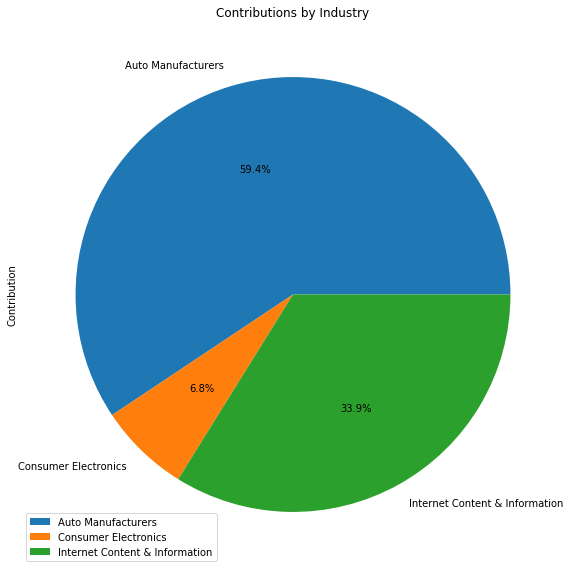

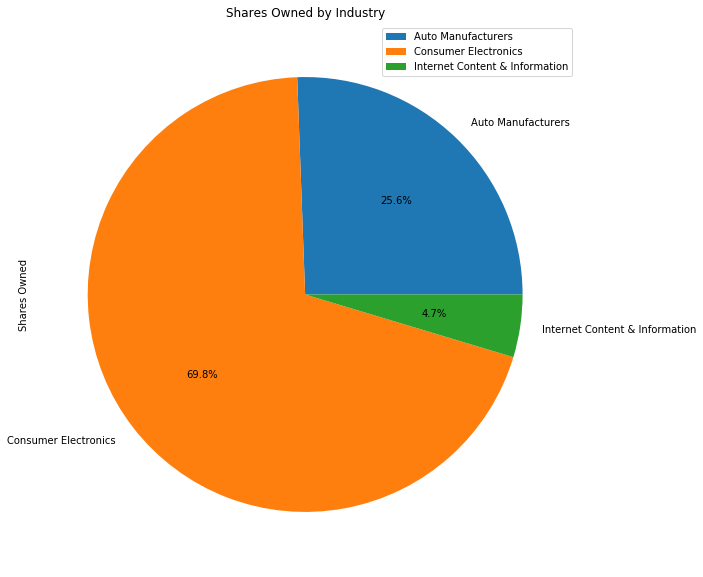

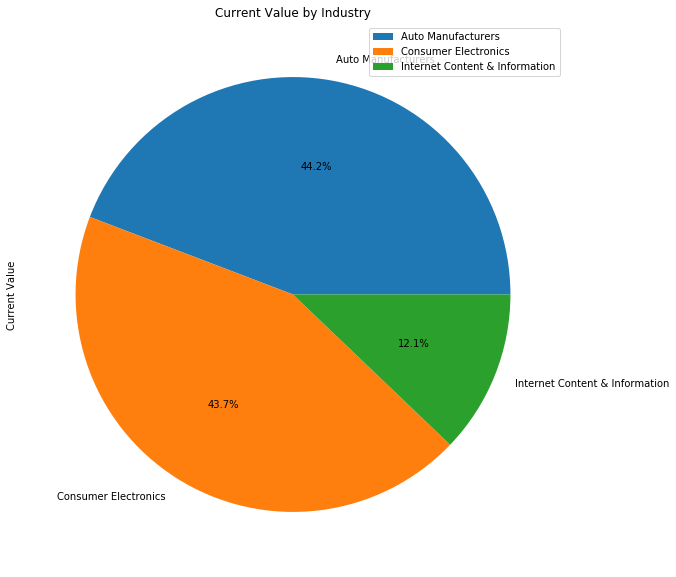

In [23]:
industry_contribution_pie=industry_holdings.plot(kind="pie", y="Contribution", figsize=(10, 10), legend=True, title="Contributions by Industry", autopct='%1.1f%%')
industry_shares_pie=industry_holdings.plot(kind="pie", y="Shares Owned", figsize=(10, 10), legend=True, title="Shares Owned by Industry", autopct='%1.1f%%')
industry_value_pie=industry_holdings.plot(kind="pie", y="Current Value", figsize=(10, 10), legend=True, title="Current Value by Industry", autopct='%1.1f%%')


In [24]:
sector_holdings= current_industry_holdings.groupby("Sector").sum()

sector_holdings

,Shares Owned,Contribution,Current Value
Sector,,,
Communication Services,10.0,9153.9,14131.8
Consumer Cyclical,55.0,16051.5,51440.4
Technology,150.0,1837.0,50820.0


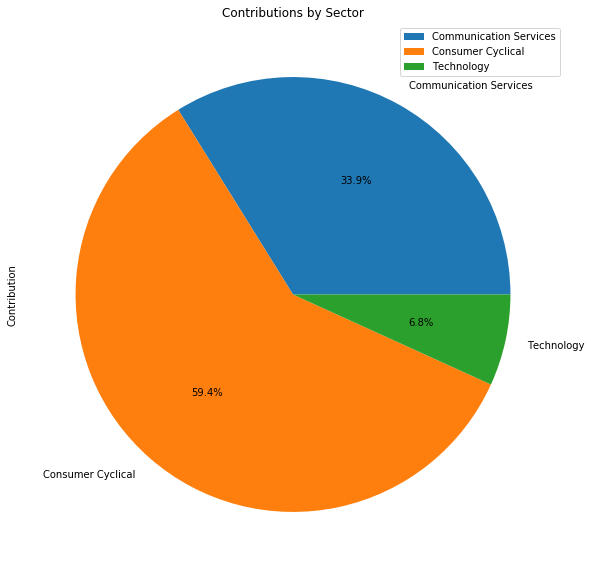

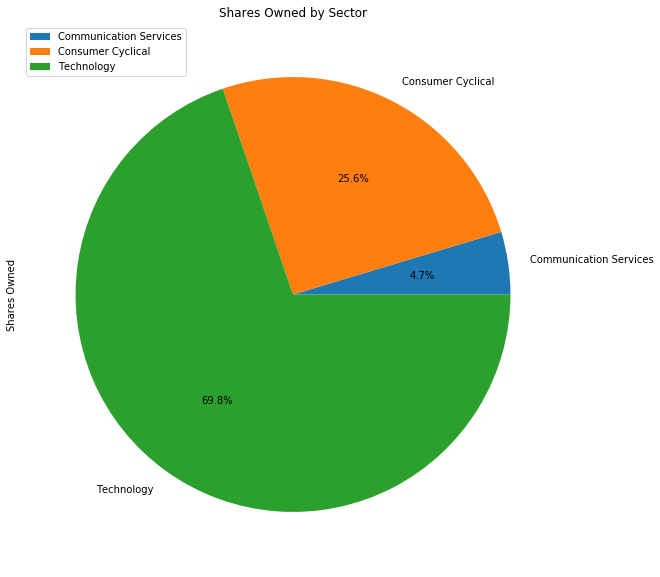

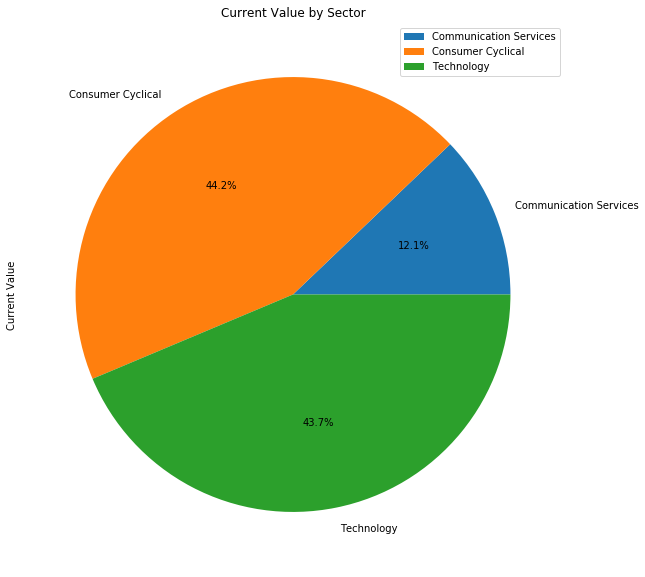

In [25]:

sector_contribution_pie=sector_holdings.plot(kind="pie", y="Contribution", figsize=(10, 10), legend=True, title="Contributions by Sector", autopct='%1.1f%%')
sector_shares_pie=sector_holdings.plot(kind="pie", y="Shares Owned", figsize=(10, 10), legend=True, title="Shares Owned by Sector", autopct='%1.1f%%')
sector_value_pie=sector_holdings.plot(kind="pie", y="Current Value", figsize=(10, 10), legend=True, title="Current Value by Sector", autopct='%1.1f%%')

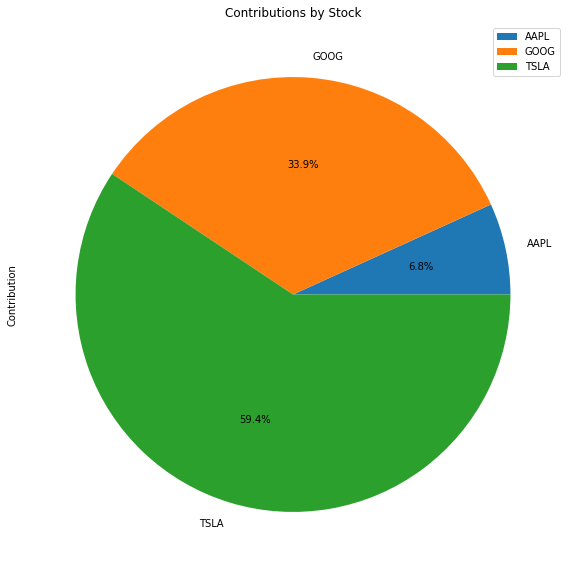

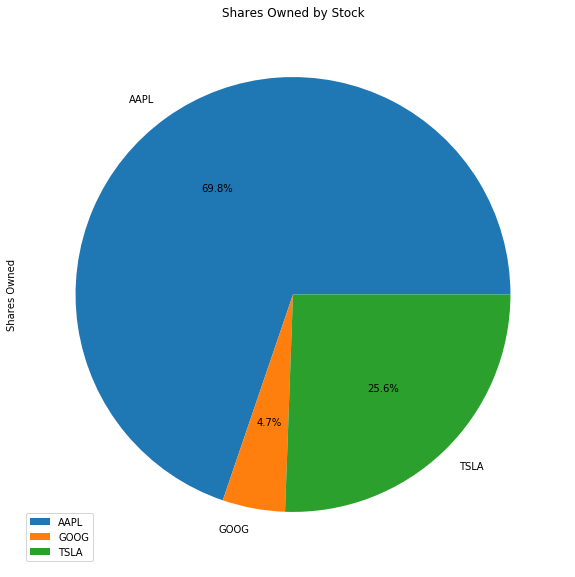

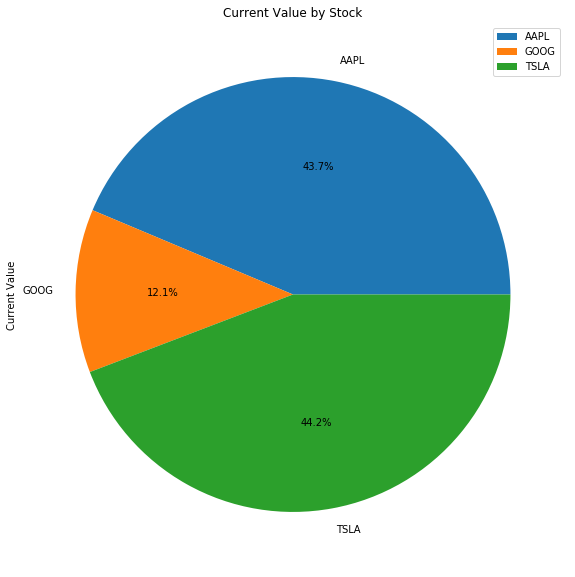

In [26]:
holdings_contribution_pie=current_holdings_df2.plot(kind="pie", labels=current_holdings_df2["Ticker"], y="Contribution", figsize=(10, 10), legend=True, title="Contributions by Stock", autopct='%1.1f%%')
holdings_shares_pie=current_holdings_df2.plot(kind="pie", labels=current_holdings_df2["Ticker"], y="Shares Owned", figsize=(10, 10), legend=True, title="Shares Owned by Stock", autopct='%1.1f%%')
holdings_value_pie=current_holdings_df2.plot(kind="pie", labels=current_holdings_df2["Ticker"], y="Current Value", figsize=(10, 10), legend=True, title="Current Value by Stock", autopct='%1.1f%%')